# 模型选择、欠拟合和过拟合
通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

使用三阶多项式来生成训练和测试数据的标签

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.1783],
         [0.8801]]),
 tensor([[1.0000e+00, 1.1783e+00, 6.9420e-01, 2.7266e-01, 8.0319e-02, 1.8928e-02,
          3.7172e-03, 6.2570e-04, 9.2159e-05, 1.2066e-05, 1.4217e-06, 1.5229e-07,
          1.4954e-08, 1.3554e-09, 1.1408e-10, 8.9610e-12, 6.5992e-13, 4.5741e-14,
          2.9942e-15, 1.8569e-16],
         [1.0000e+00, 8.8007e-01, 3.8726e-01, 1.1361e-01, 2.4996e-02, 4.3996e-03,
          6.4533e-04, 8.1134e-05, 8.9255e-06, 8.7279e-07, 7.6812e-08, 6.1455e-09,
          4.5070e-10, 3.0512e-11, 1.9180e-12, 1.1253e-13, 6.1899e-15, 3.2045e-16,
          1.5668e-17, 7.2572e-19]]),
 tensor([5.5817, 5.5428]))

# 对模型进行训练和测试
实现一个函数来评估模型在给定数据集上的损失

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', 
                            ylabel='loss', 
                            yscale='log',
                            xlim=[1, num_epochs], 
                            ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

# 三阶多项式函数拟合(正态)

weight: [[ 5.0064425  1.1967741 -3.4098287  5.6034336]]


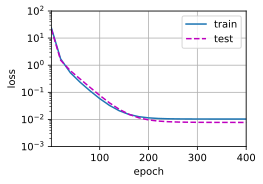

In [6]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], 
      poly_features[n_train:, :4],
      labels[:n_train], 
      labels[n_train:])

# 线性函数拟合(欠拟合)

weight: [[3.4433022 3.3676653]]


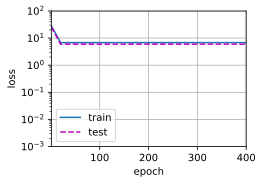

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], 
      poly_features[n_train:, :2],
      labels[:n_train], 
      labels[n_train:])

# 高阶多项式函数拟合(过拟合)

weight: [[ 4.9962544e+00  1.2877085e+00 -3.3517611e+00  5.1416259e+00
  -1.4224802e-01  1.2702101e+00  4.1980524e-02  5.8753069e-02
  -1.9335969e-01  2.3016757e-01  9.2654482e-02 -1.9439161e-01
   1.3923757e-01  8.7759577e-02  2.8465766e-02  2.0042711e-01
  -8.7468654e-02 -1.4094143e-01 -1.7227530e-02  2.6436597e-03]]


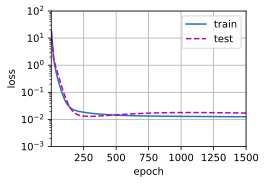

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], 
      poly_features[n_train:, :],
      labels[:n_train], 
      labels[n_train:], 
      num_epochs=1500)